

---


## Data and tool imports



---



In [0]:
# Import data tools
import pandas as pd
import numpy as np
!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

# Read dataset csv and instantiate dataframe
df = pd.read_csv('/content/top10s.csv')



---

## Data Cleaning

---



In [0]:
# Drop columns that provide little to no value
df = df.drop(['Unnamed: 0', 'title', 'artist'], axis=1)

# Rename columns making features more relateable
df.rename(columns = {'top genre': 'top_genre', 'bpm': 'beats_per_minute', 'nrgy': 'energy', 
                       'dnce': 'danceability', 'dB': 'loudness(dB)', 'live': 'liveness', 
                       'val': 'valence', 'dur': 'length', 'acous': 'acousticness', 
                       'spch': 'speechiness', 'pop': 'popularity'}, inplace=True)

#Re-ordering columns in df
df = df[['acousticness', 'beats_per_minute' , 'danceability','energy', 'length', 'liveness','loudness(dB)', 'popularity', 'speechiness','valence','year','top_genre']]

In [7]:
# Combine top_genre categories
df['top_genre'] = df['top_genre'].str.lower()

# Find all instances of top_genre containing keywords
pop = df['top_genre'].str.contains('pop')
raprb = df['top_genre'].str.contains('hip|rap|r&b')
edm = df['top_genre'].str.contains('elect|room|house|step|edm')

# Define pop/raprb/edm/other variables
df.loc[pop, 'top_genre'] = 'pop'
df.loc[raprb, 'top_genre'] = 'rap / r&b'
df.loc[edm, 'top_genre'] = 'electronic dance'
df.loc[~pop & ~raprb & ~edm, 'top_genre'] = 'other'

df['top_genre'].value_counts()

pop                 466
other                63
electronic dance     43
rap / r&b            31
Name: top_genre, dtype: int64



---

## Exploring the data

---



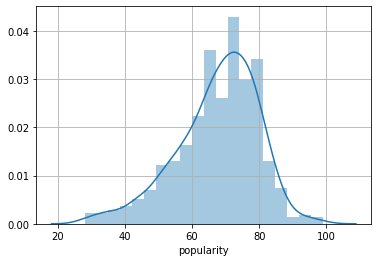

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Visualize the target
ax = sns.distplot(df['popularity'])
ax.grid()
plt.show()

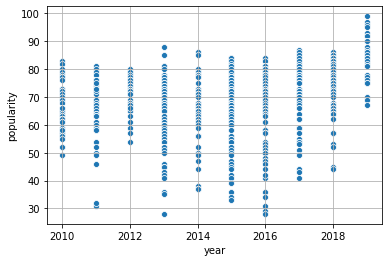

In [9]:
# Visualize the target in comparison to year
ax = sns.scatterplot(df['year'], df['popularity'])
ax.grid()
plt.show()

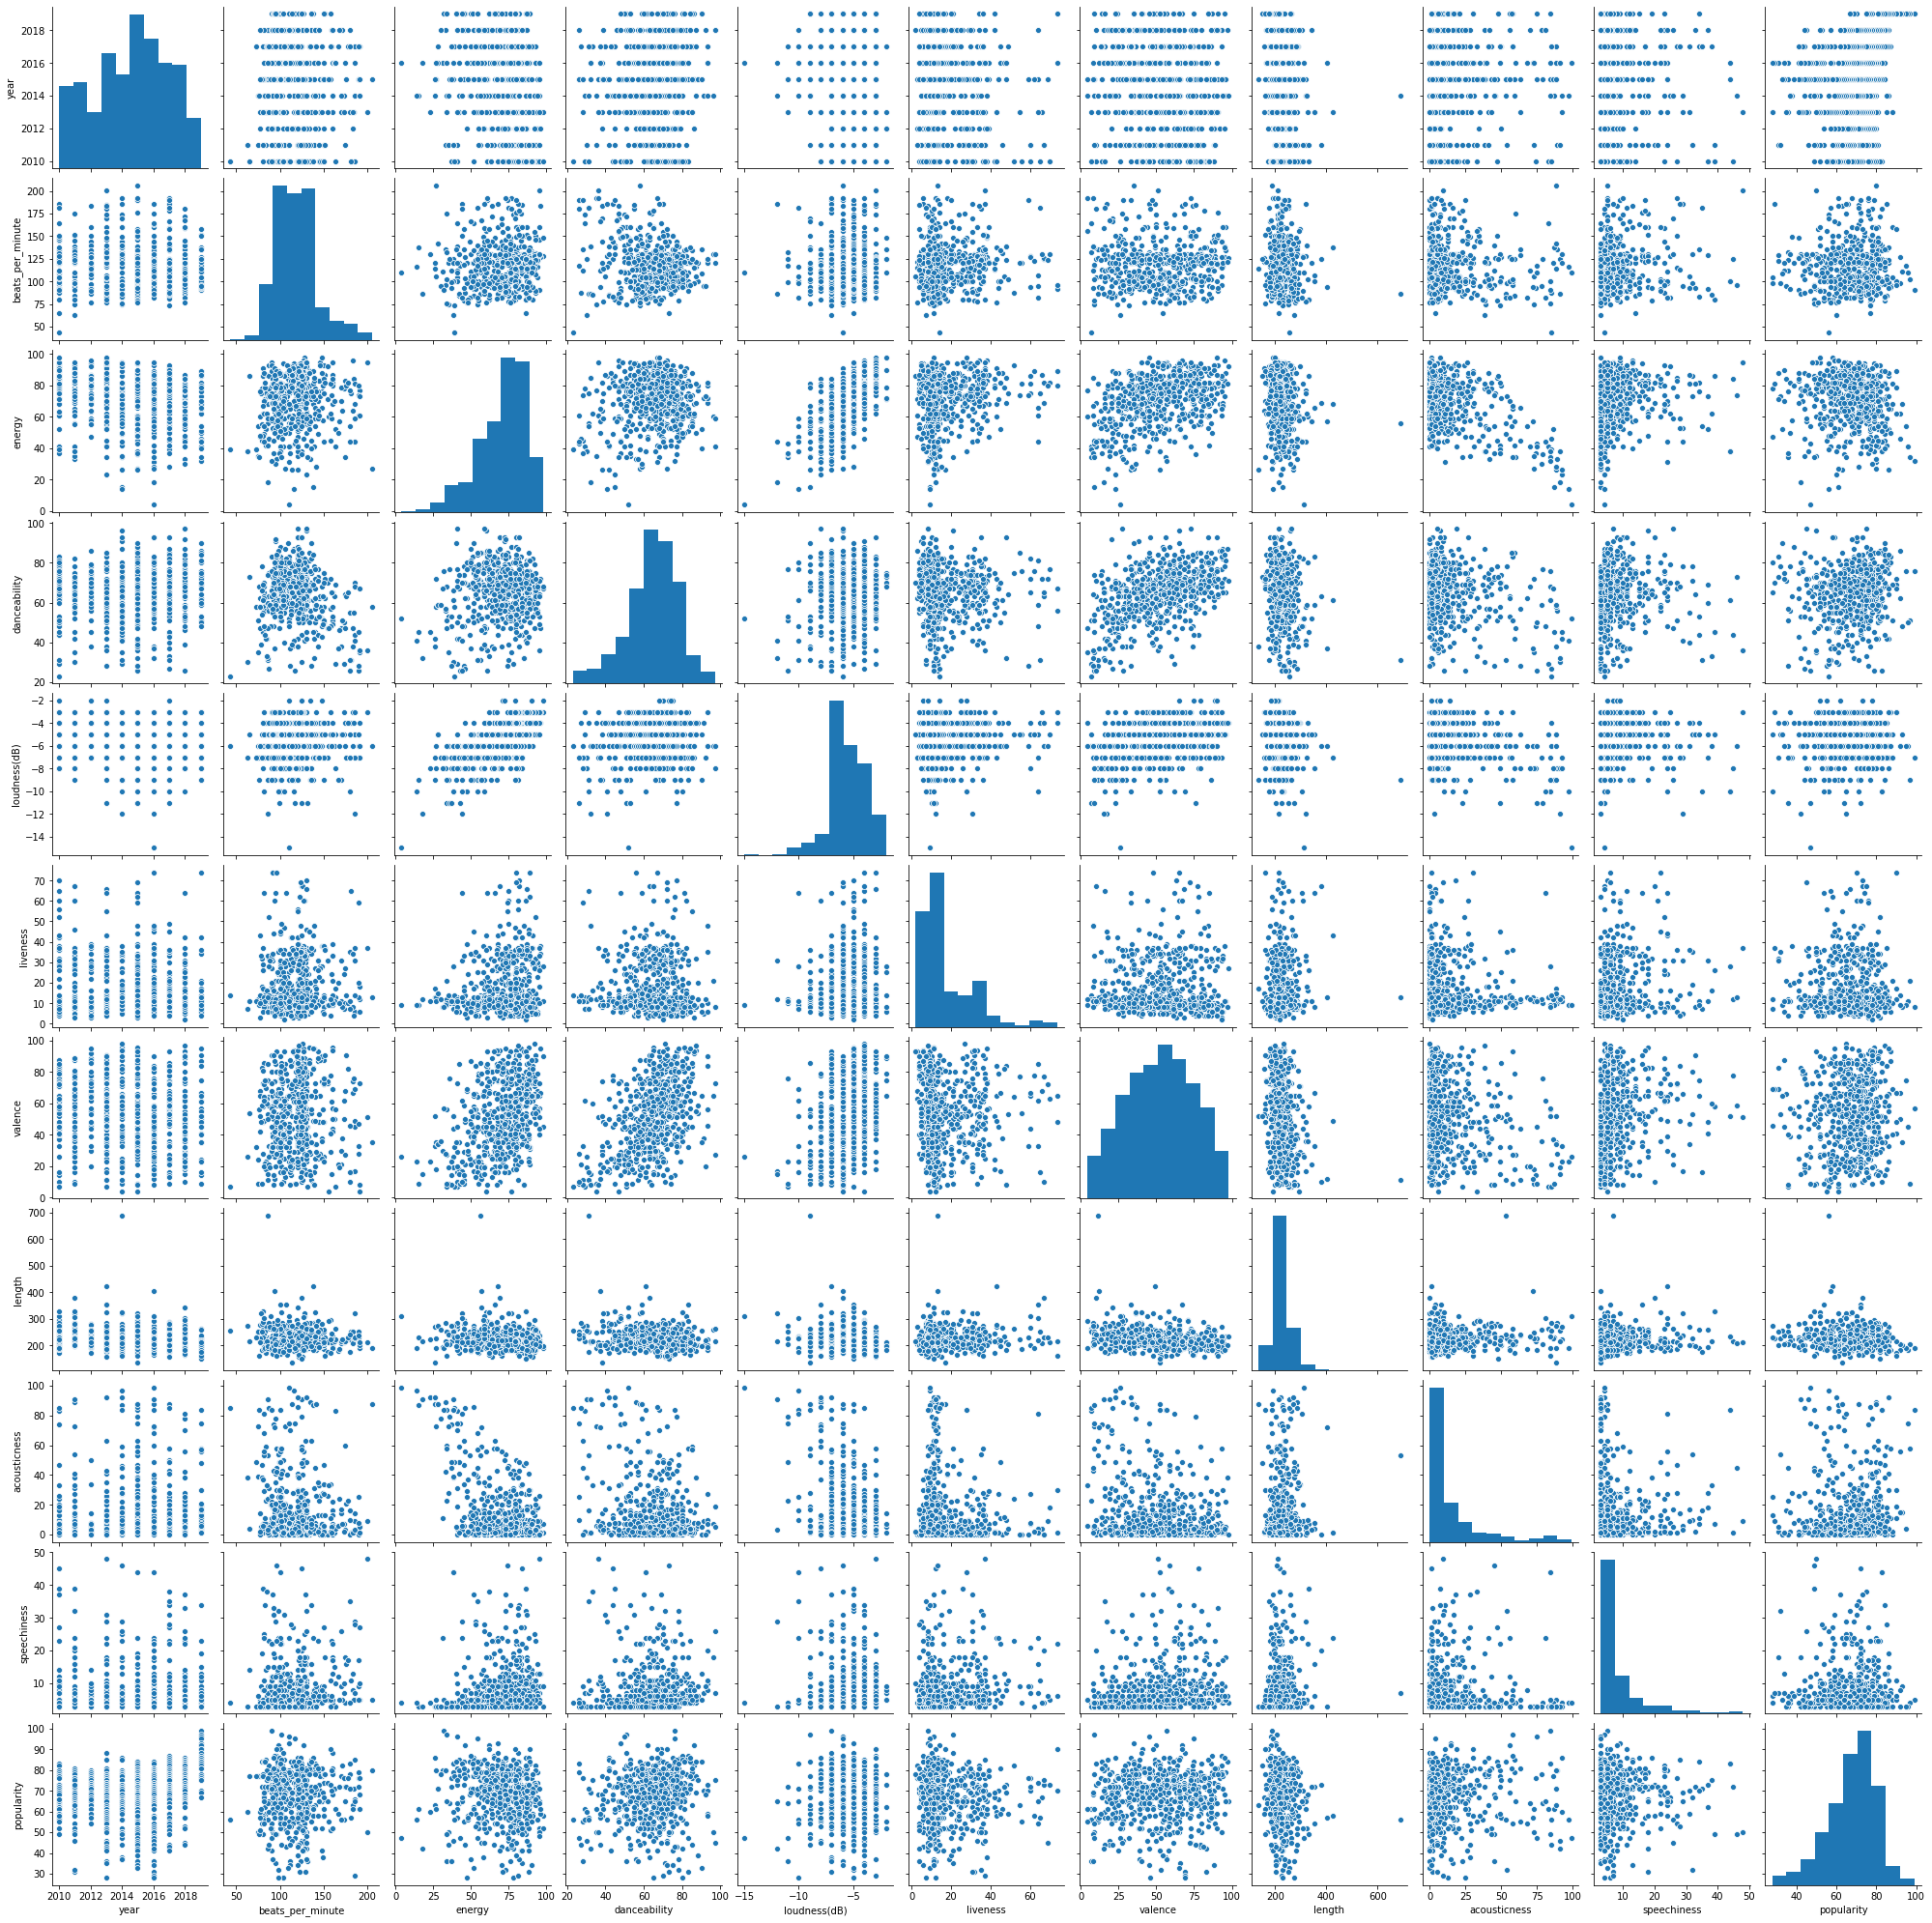

In [0]:
# Visualize comparison of target to features
sns.pairplot(df)
plt.show()

---
## Baseline for regression
---

In [10]:
# Mean Baseline (Regression, 'popularity' = target)
guess = df['popularity'].mean()
errors = guess - df['popularity']
mean_absolute_error = errors.abs().mean()
print(f'If we just guessed every song had a popularity of {guess:,.0f}%,')
print(f'we would be off by {mean_absolute_error:.2f} popularity on average.')

If we just guessed every song had a popularity of 68%,
we would be off by 9.56 popularity on average.




---

## Random test / train split

---



In [11]:
from sklearn.model_selection import train_test_split

# Split data in train / test sets (80%/20%)
train, test = train_test_split(df, train_size=.80, random_state=7)

train.shape, test.shape

((482, 12), (121, 12))

In [0]:
# Designate target & features
target = 'popularity'
features = train.columns.drop([target])

#Assign target/features to train/test set
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

---
## Fit a linear model
---

In [55]:
# Import and perform one-hot encoding
import category_encoders as ce

# Instantiate one-hot encoder
encoder = ce.OneHotEncoder()

# Fit and transform on train/test sets
X_train1 = encoder.fit_transform(X_train)
X_test1 = encoder.transform(X_test)

X_train1

acousticness  beats_per_minute  ...  top_genre_3  top_genre_4
235             8                82  ...            0            0
449            43                93  ...            0            0
32              8               120  ...            0            0
22              0               125  ...            0            0
592            57               125  ...            0            0
..            ...               ...  ...          ...          ...
579            19               100  ...            0            1
502            14               113  ...            0            0
537            20               128  ...            0            0
196            43               103  ...            0            0
175             4               130  ...            0            0

[482 rows x 14 columns]

In [0]:
from sklearn.linear_model import LinearRegression
# Instantiate model class
model = LinearRegression()
# Fit the model
model.fit(X_train1, y_train)
# Apply the model to new data
y_pred1 = model.predict(X_train1)
y_pred2 = model.predict(X_test1)

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MAE and R2 for training data
mae = mean_absolute_error(train[target], y_pred1)
r2 = r2_score(train[target], y_pred1)

print(f'The MAE of the training data is {mae}')
print(f'The R2 of the training data is {r2}')

# MAE and R2 for test data
mae = mean_absolute_error(test[target], y_pred2)
r2 = r2_score(test[target], y_pred2)

print(f'The MAE of the test data is {mae}')
print(f'The R2 of the test data is {r2}')

The MAE of the training data is 8.495644123334463
The R2 of the training data is 0.13134091771616507
The MAE of the test data is 10.61814801418565
The R2 of the test data is -0.017150430553706242




---

## Fit a tree-based model - R^2

---



In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# Instantiate pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=7))


# Designate parameters for randomsearchCV
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestregressor__n_estimators': [50, 100, 200, 300, 500],
    'randomforestregressor__max_depth': [2, 5, 8, 10, 15, 20, 30, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
    'randomforestregressor__min_samples_split': [1, 2, 3, 4],
    'randomforestregressor__min_samples_leaf': [1, 2, 3, 4],
}

# Instantiate randomizedsearchCV
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=3, 
    scoring='r2', 
    verbose=10, 
    return_train_score=True,
    random_state=7, 
    n_jobs=-1
)

# Fit the model 
search.fit(X_train1, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.0s finished


In [35]:
# Best parameters and R2 from our RandomForestRegressor
print('Best hyperparameters', search.best_params_)
print('Cross-validation R2', search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.0014268805627581926, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 100, 'simpleimputer__strategy': 'median'}
Cross-validation R2 0.13542077859300997


In [20]:
# Instantiate pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=7))

# Designate parameters for randomsearchCV
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestregressor__n_estimators': [50, 100, 200, 300, 500],
    'randomforestregressor__max_depth': [2, 5, 8, 10, 15, 20, 30, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
    'randomforestregressor__min_samples_split': [1, 2, 3, 4],
    'randomforestregressor__min_samples_leaf': [1, 2, 3, 4],
}

# Instantiate randomizedsearchCV
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    random_state=7,
    n_jobs=-1
)

# Fit the model 
search.fit(X_train1, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.9s finished


In [21]:
# Best MAE from our RandomForestRegressor
print('Cross-validation MAE', -search.best_score_)

Cross-validation MAE 8.594644580162262




---

## Create model for visualizations - Using parameters from CV above


---



In [68]:
# Remove from pipeline in order to chart
# results of RFR Parameter tuning

# Set up RFR model
model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            max_features=0.0014268805627581926,
            min_samples_split=4,
            min_samples_leaf=2,
            random_state=7
)

# Define eval_set
eval_set = [(X_train1, y_train),
           (X_test1, y_test)]

# Fit model, with early stopping rounds
model.fit(X_train1, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.0014268805627581926,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=7, verbose=0,
                      warm_start=False)



---

## Model importances and visualizations


---



In [69]:
import eli5
from eli5.sklearn import PermutationImportance

# Instantiate permuter for RandomForestRegressor
permuter = PermutationImportance(
    model,
    cv='prefit',
    scoring='r2',
    n_iter=5,
    random_state=7
)
# Fit permuter to data from our model
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=0.0014268805627581926,
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=2,
                                                      min_samples_split=4,
                                                      min_weight_fraction_leaf=0.0,
                                                      n

In [70]:
# Pull out top features and their importance
feature_names = X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

top_genre_2         0.014846
top_genre_4         0.021589
top_genre_3         0.053917
top_genre_1         0.082423
speechiness         0.089840
beats_per_minute    0.096523
loudness(dB)        0.101180
valence             0.102200
danceability        0.106458
acousticness        0.107138
liveness            0.111915
length              0.128969
energy              0.132143
year                0.168033
dtype: float64

In [71]:
# Visualize feature importances 
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

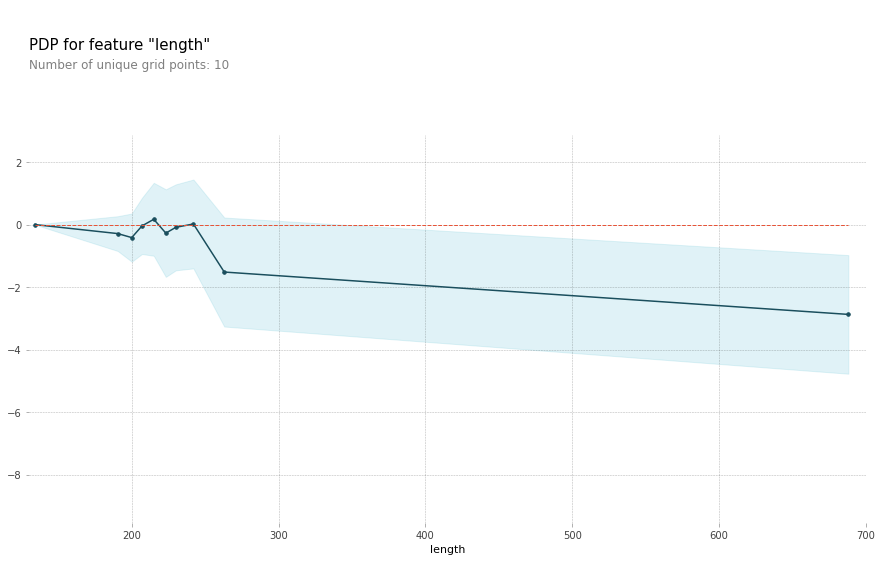

In [78]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Designate feature to analyze
feature = 'length'

# Instantiate isolated conditional plot
isolated = pdp_isolate(
    model=model,
    dataset=X_train1,
    model_features=X_train1.columns,
    feature=feature
)
# Visualize pdp plot
pdp_plot(isolated, feature_name=feature)
plt.xlim((130, 700));

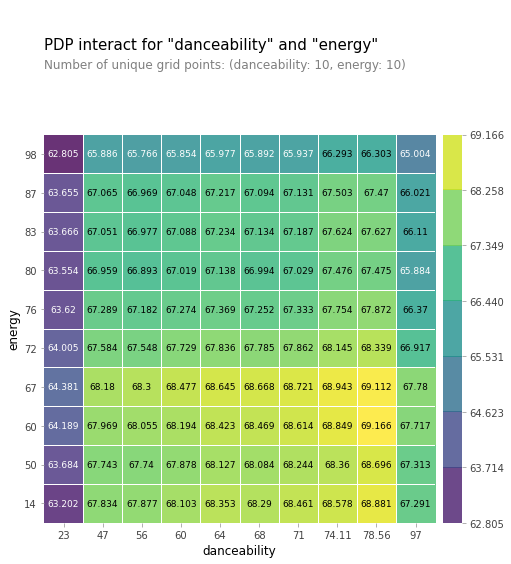

In [79]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Designating multiple features for comparison
features = ['danceability', 'energy']

# Instantiate interaction conditional plot
interaction = pdp_interact(
    model=model,
    dataset=X_train1,
    model_features=X_train1.columns,
    features=features
)

# Visualize pdp_interact plot 
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [80]:
import shap
# Instantiate individual prediction
row = X_train1.iloc[[0]]

# Instantiate TreeExplainer
explainer = shap.TreeExplainer(model)

# Pull shap values for individual observation
shap_values = explainer.shap_values(row)

# Visualize feature importance on individual prediction
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [77]:
# Predicting across X_train_encoded 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train1)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=X_train
)



---

## Reproducibility of the model

---



In [0]:
# Retrieve version types to install in pipenv shell
import joblib
import sklearn
import category_encoders as ce
import scipy

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'scipy=={scipy.__version__}')

joblib==0.14.1
scikit-learn==0.22.2.post1
category_encoders==2.2.2
scipy==1.4.1


In [0]:
# Pickle the model and download locally
from joblib import dump
dump(search, 'RFRpipeline.joblib', compress=True)

['RFRpipeline.joblib']